In [1]:
from utils import *
from MySolution import *
import scipy
from itertools import combinations
import ortools
import cvxpy as cp

%load_ext autoreload
%autoreload 2

In [2]:
cp.installed_solvers()

['CLARABEL',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLOP',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'PDLP',
 'SCIPY',
 'SCS']

Synthetic data shape:  (1000, 2) (1000,)


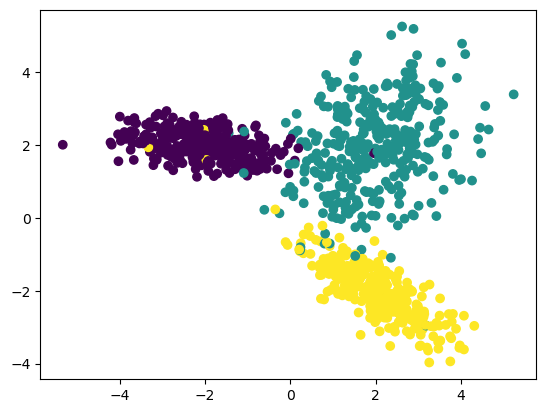

In [27]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

In [3]:
n, f, k = 1000, 3, 3

X = np.concat([syn_data['trainX'], np.ones((n,1))], axis=1)
Y = syn_data['trainY']
c = np.concat([np.zeros(f), np.ones(n)])
S = np.ones(n)
S[Y != 1] = -1
A_ub = np.concat([-S[:,None]*X, -np.eye(n)], axis=1)
b_ub = -np.ones(n)
bounds = [(None, None)]*f + [(0, None)]*n

In [4]:
res = scipy.optimize.linprog(c, A_ub, b_ub, bounds=bounds)
assert res['success']

In [5]:
a = res['x'][:f]
a

array([ 1.65582689,  1.58078658, -2.38936728])

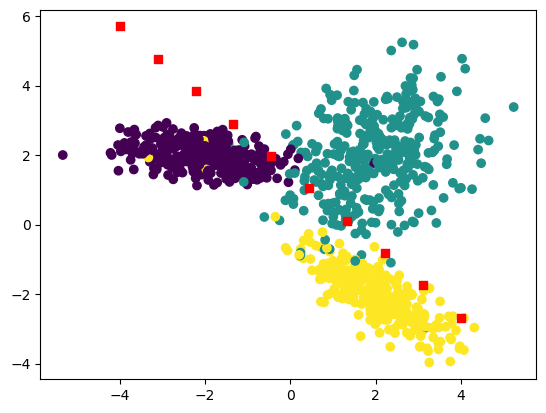

In [6]:
x1 = np.linspace(-4,4,10)
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])
plt.scatter(x1, (1/a[1])*(-a[2]-x1*a[0]), c='red', marker=',')

In [7]:
classifier = OneAgainstAll(3)
classifier.train(syn_data['trainX'], syn_data['trainY'])

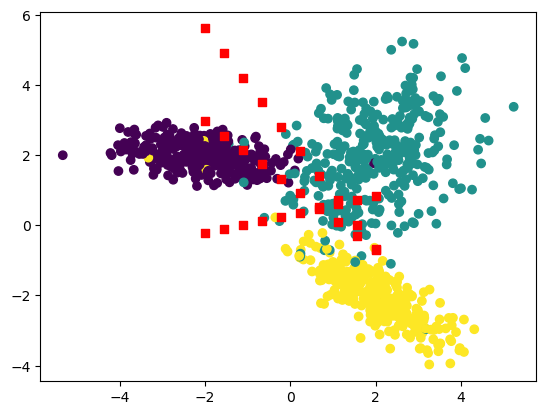

In [8]:
x1 = np.linspace(-2,2,10)
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])
for a in classifier.a_s:
#     x1 = np.linspace(-4,4,10)/np.linalg.norm(a, ord=2)
    plt.scatter(x1, (1/a[1])*(-a[2]-x1*a[0]), c='red', marker=',')


In [9]:
i = 100
classifier.predict(syn_data['trainX'][i:i+10]), syn_data['trainY'][i:i+10]

(array([2, 0, 2, 2, 2, 1, 0, 0, 1, 0]),
 array([2., 0., 2., 2., 2., 1., 0., 0., 1., 0.]))

In [10]:
classifier.evaluate(syn_data['trainX'], syn_data['trainY'])

0.97

In [11]:
classifier.evaluate(syn_data['testX'], syn_data['testY'])

0.978

In [113]:
X_train = np.concat([syn_data['trainX'], np.ones((syn_data['trainX'].shape[0], 1))], axis=1)
centroids = []
for i in range(3):
    centroids.append(
        X_train[syn_data['trainY'] == i, :].mean(axis=0)
    )
    pass
centroids = np.array(centroids)
X_test = np.concat([syn_data['testX'], np.ones((syn_data['testX'].shape[0], 1))], axis=1)
# x - centroids

In [114]:
centroids - X_test[0]

array([[-6.85513648e-01,  2.27929316e-02,  0.00000000e+00],
       [ 3.28535384e+00,  1.58068974e-03,  0.00000000e+00],
       [ 3.32678397e+00, -3.92380440e+00,  0.00000000e+00]])

In [116]:
(x.shape[0], centroids.shape[0], x.shape[1])

(500, 3, 3)

In [134]:
x_ = np.broadcast_to(x[:,None,:],(x.shape[0], centroids.shape[0], x.shape[1]))
diffs = x_ - centroids
f1 = np.linalg.norm(diffs, ord=2, axis=2)
print(f1.shape)
f2 = (x@centroids.T)/(np.linalg.norm(x, ord=2, axis=1, keepdims=True)@(np.linalg.norm(centroids, ord=2, axis=1)[None,:]))
print(f2.shape)

(500, 3)
(500, 3)


In [128]:
(x@centroids.T).shape

(500, 3)

In [129]:
np.linalg.norm(x, ord=2, axis=1, keepdims=True).shape

(500, 1)

In [132]:
np.linalg.norm(centroids, ord=2, axis=1).T.shape

(3,)

In [56]:
y = syn_data['trainY']
x = syn_data['trainX']

x_ = x[y == 0, :]
U, s, Vt = np.linalg.svd(x_, full_matrices=False)
S = np.diag(s)
# Mhat = np.dot(U, np.dot(S, Vt))
# Mhat = U@S@Vt
PC = np.sqrt(S)@Vt

In [57]:
PC.shape

array([[ 5.50817101, -4.92089456],
       [ 2.17958469,  2.43970381]])

In [58]:
tmp = np.array([[1,2,3],[4,5,6]])

In [62]:
tmp.sign()

AttributeError: 'numpy.ndarray' object has no attribute 'sign'

In [35]:
classifier = OneAgainstAll(3)
classifier.train(syn_data['trainX'], syn_data['trainY'])
print(classifier.evaluate(syn_data['trainX'], syn_data['trainY']))
print(classifier.evaluate(syn_data['testX'], syn_data['testY']))

/home/andrea/git/UCLA/Linear_Programming_ECE236A/Code/Code/MySolution.py:70: RuntimeWarning: Mean of empty slice.
  self.centroids.append(X[Y == i, :].mean(axis=0))


LinAlgError: SVD did not converge

In [34]:
%pdb

Automatic pdb calling has been turned OFF


In [164]:
classifier = OneAgainstOne(3)
classifier.train(syn_data['trainX'], syn_data['trainY'])
print(classifier.evaluate(syn_data['trainX'], syn_data['trainY']))
print(classifier.evaluate(syn_data['testX'], syn_data['testY']))

0.973
0.978


In [8]:
classifier = OneAgainstAll_MIP(3, 2)
classifier.train(syn_data['trainX'], syn_data['trainY'])
print(classifier.evaluate(syn_data['trainX'], syn_data['trainY']))
print(classifier.evaluate(syn_data['testX'], syn_data['testY']))

0.972
0.976


In [ ]:
classifier.A[]

In [54]:
x_.shape

(340, 2)

MNIST data shape:  (1000, 784) (1000,)


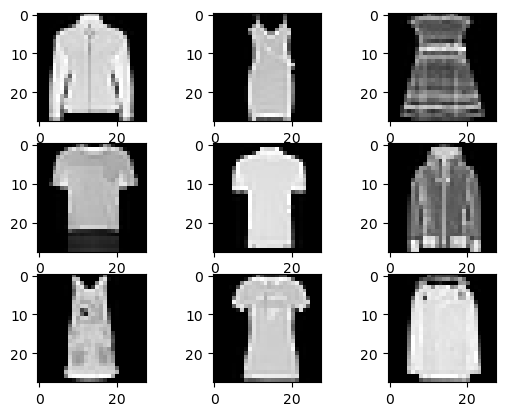

In [4]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)
# print(mnist_data['trainX'].shape)
for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

In [6]:
# Some preprocessing
mnist_data['trainY'][mnist_data['trainY'] >= 3] -= 2
mnist_data['testY'][mnist_data['testY'] >= 3] -= 2

In [45]:
mnist_data['trainX'].shape

(1000, 784)

In [5]:
classifier = OneAgainstAll(3)
classifier.train(mnist_data['trainX'], mnist_data['trainY'])
print(classifier.evaluate(mnist_data['trainX'], mnist_data['trainY']))
print(classifier.evaluate(mnist_data['testX'], mnist_data['testY']))

1.0
0.92


In [ ]:
classifier = OneAgainstAll_MIP(3, 5)
classifier.train(mnist_data['trainX'], mnist_data['trainY'])
print(classifier.evaluate(mnist_data['trainX'], mnist_data['trainY']))
print(classifier.evaluate(mnist_data['testX'], mnist_data['testY']))

In [22]:
classifier.a_s.shape

(3, 803)

In [27]:
feature_weights = np.abs(classifier.a_s).sum(axis=0)

In [30]:
(feature_weights == 0).sum() # Number of features that are to be ignored

np.int64(511)

In [33]:
feature_weights

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.71023897e-03, 0.00000000e+00, 1.37672161e-03,
       3.44972222e-03, 1.12833462e-02, 6.64483144e-03, 8.44500874e-03,
       7.42665383e-05, 4.91729592e-04, 9.07963258e-03, 5.84961133e-03,
       1.59038675e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.25909738e-03, 6.16692262e-03,
       7.59831184e-03, 2.68478411e-04, 1.12296030e-04, 6.60399304e-03,
       2.44237948e-03, 2.62018189e-03, 4.03780928e-03, 1.73766687e-04,
       7.47767016e-04, 4.60146960e-03, 1.31794403e-03, 3.57107540e-03,
       3.68978528e-03, 7.90103373e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [36]:
feature_weights.argsort()[::-1][:100]

array([802, 201,  20,  64, 679, 482, 409, 147, 106, 369, 749, 243, 366,
       455, 297,  13, 490, 216, 132,  18, 378, 186, 454, 610, 259,  15,
       245, 747,  34, 584, 184, 203, 685,  49,  36, 598, 632, 244, 183,
       500, 397, 405, 404,  96, 710, 776, 456, 484, 182,  14, 736,  39,
       460, 495, 498,  78,  35, 708, 661, 464, 424,  71, 204, 551, 663,
        19, 735, 742,   9, 402, 511, 693, 256, 159,  70, 406, 343, 566,
       665, 539, 440, 497, 151, 411, 332,  98,  45, 546,  68, 705, 413,
       763, 596, 594, 294,  42, 373, 125, 605, 274])

In [ ]:
(feature_weights.argsort()[::-1][:100] >=784).sum()

In [13]:
classes = np.array([0,3,4])
Y = np.array([0,0,2,2,1,0,2,1,0])

In [6]:
classes[Y]

array([0, 0, 4, 4, 3, 0, 4, 3, 0])

In [25]:
y_p = np.array([0, 0, 4, 4, 3, 0, 4, 3, 0])

In [8]:
np.where(Y == classes)

ValueError: operands could not be broadcast together with shapes (9,) (3,) 

In [17]:
np.where(np.in1d(y_p, classes))

/tmp/ipykernel_43167/613441681.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.where(np.in1d(y_p, classes))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),)

In [26]:
np.searchsorted(y_p, np.intersect1d(classes, y_p))

array([0, 2, 9])

In [22]:
np.intersect1d(classes, y_p)

array([0, 3, 4])

In [20]:
np.sort([3,24,1,5])

array([ 1,  3,  5, 24])

In [26]:
classifier = OneAgainstOne(3)
classifier.train(mnist_data['trainX'], mnist_data['trainY'])
print(classifier.evaluate(mnist_data['trainX'], mnist_data['trainY']))
print(classifier.evaluate(mnist_data['testX'], mnist_data['testY']))

NameError: name 'OneAgainstOne' is not defined

In [57]:
(classifier.A == 0).sum()

np.int64(7184)

In [59]:
classifier.A.shape

(3, 3, 831)

In [64]:
classifier.A.size

7479

In [78]:
classifier = Robin(3)
classifier.train(mnist_data['trainX'], mnist_data['trainY'])
print(classifier.evaluate(mnist_data['trainX'], mnist_data['trainY']))
print(classifier.evaluate(mnist_data['testX'], mnist_data['testY']))

1.0
0.908


In [75]:
[1,2,3][:-1]

[1, 2]

In [37]:
[1,*(2,3)]

[1, 2, 3]

In [33]:
%pdb

Automatic pdb calling has been turned ON


In [25]:
U, s, Vt = np.linalg.svd(mnist_data['trainX'], full_matrices=False)

In [26]:
U.shape, s.shape, Vt.shape

((1000, 784), (784,), (784, 784))

In [27]:
U, s, Vt = np.linalg.svd(syn_data['trainX'], full_matrices=False)

In [28]:
U.shape, s.shape, Vt.shape

((1000, 2), (2,), (2, 2))

In [ ]:
1.0, 0.912

In [168]:
preds = classifier.predict(mnist_data['testX'])
np.where(preds != mnist_data['testY'])

(array([ 10,  12,  15,  18,  29,  32,  36,  39,  40,  41,  42,  45,  49,
         56,  57,  73,  76,  80,  85,  90,  93,  99, 107, 111, 123, 127,
        133, 136, 142, 143, 144, 146, 154, 155, 157, 160, 162, 170, 175,
        176, 177, 178, 179, 180, 185, 187, 188, 191, 195, 197, 205, 210,
        219, 222, 225, 233, 237, 246, 249, 252, 254, 256, 258, 262, 266,
        270, 271, 273, 274, 275, 277, 279, 281, 282, 288, 289, 291, 292,
        293, 295, 302, 303, 304, 306, 307, 313, 314, 317, 334, 336, 338,
        339, 340, 348, 349, 350, 355, 362, 369, 370, 371, 372, 373, 374,
        380, 382, 386, 387, 398, 413, 417, 424, 427, 434, 437, 440, 441,
        445, 446, 457, 462, 474, 478, 499]),)

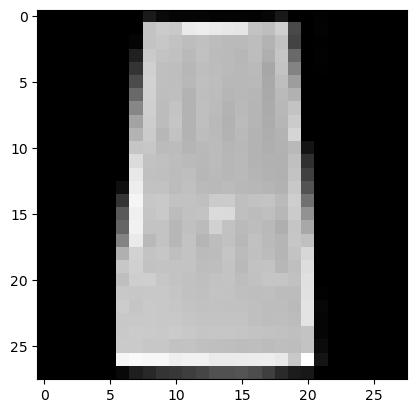

In [179]:
plt.imshow(mnist_data['testX'][12].reshape(28,28), cmap='gray')

In [173]:
preds[10]

np.int64(0)

In [174]:
mnist_data['testY'][10]

np.float64(1.0)

In [177]:
np.where(mnist_data['trainY'] == 0)

(array([  3,   4,   7,  11,  14,  16,  19,  28,  29,  32,  37,  39,  41,
         43,  46,  48,  51,  52,  53,  61,  67,  69,  73,  74,  75,  81,
         83,  85,  87,  93,  95, 102, 103, 104, 107, 108, 110, 112, 116,
        124, 128, 129, 134, 135, 139, 147, 148, 150, 152, 154, 160, 162,
        166, 167, 168, 171, 175, 176, 180, 189, 190, 192, 195, 198, 204,
        208, 210, 212, 213, 215, 223, 231, 233, 234, 236, 238, 239, 247,
        251, 254, 259, 260, 262, 264, 269, 273, 275, 276, 277, 280, 285,
        286, 292, 294, 301, 303, 307, 309, 315, 317, 320, 326, 328, 329,
        334, 336, 338, 345, 351, 352, 353, 354, 356, 357, 360, 361, 364,
        365, 367, 374, 379, 383, 387, 394, 395, 396, 400, 402, 406, 408,
        410, 414, 415, 417, 418, 419, 432, 434, 435, 439, 440, 442, 447,
        452, 460, 462, 465, 468, 470, 474, 475, 479, 480, 484, 485, 491,
        492, 493, 501, 502, 507, 509, 510, 516, 518, 522, 526, 527, 529,
        531, 538, 540, 543, 546, 549, 557, 559, 560

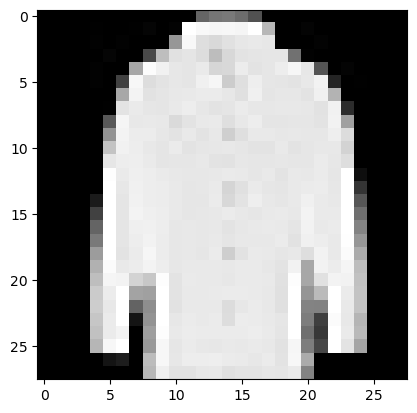

In [178]:
plt.imshow(mnist_data['testX'][3].reshape(28,28), cmap='gray')

In [19]:
X.dtype

dtype('float64')

In [38]:
X = mnist_data['trainX'].astype('float32')
Y = mnist_data['trainY'].astype('float32')
n, f = X.shape
k = int(np.max(Y)) + 1
d = np.broadcast_to(X[:,None,:],(X.shape[0], X.shape[0], X.shape[1]))
d = d - X
d = np.linalg.norm(d, ord=2, axis=2)

In [35]:
X = syn_data['trainX'].astype('float32')
Y = syn_data['trainY'].astype('float32')
n, f = X.shape
k = int(np.max(Y)) + 1
d = np.broadcast_to(X[:,None,:],(X.shape[0], X.shape[0], X.shape[1]))
d = d - X
d = np.linalg.norm(d, ord=2, axis=2)

In [39]:
# C = np.random.rand(k, f)
U, s, Vt = np.linalg.svd(X, full_matrices=False)
C = U[:k,:]@np.diag(np.sqrt(s))

In [ ]:
# # C = np.random.rand(k, f)
# U, s, Vt = np.linalg.svd(X)
# U
Y = None
loss_hist = []
for i in range(10):
    print(i)
    Y, o = kmeans_lp_y(X, C, k)
    print(i)
#     C, o = kmeans_lp_c(X_, Y, k)
    C = (Y.T/Y.sum(axis=0)[:,None])@X
    loss_hist.append(o)
plt.plot(loss_hist)
plt.show()

0


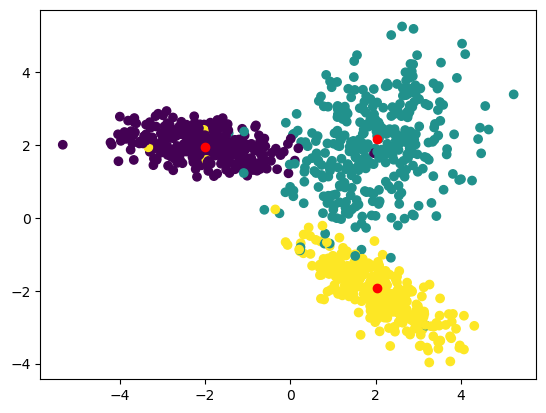

In [31]:
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])
plt.scatter(C[:,0], C[:,1], c='red')

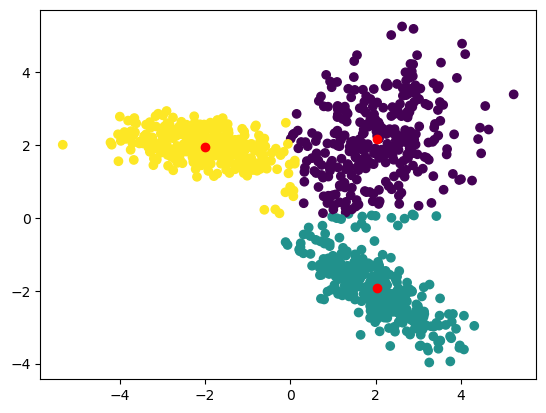

In [32]:
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=Y.argmax(axis=1))
plt.scatter(C[:,0], C[:,1], c='red')

In [14]:
scipy.__version__

'1.14.1'

In [9]:
solver = cp.SCIPY

def kmeans_lp_y(X, C, k):

    n, f = X.shape
    Y = cp.Variable((n, k), integer=True)

    objective = cp.Minimize(cp.sum(cp.abs(X-Y@C)))

    problem = cp.Problem(objective, [0 <= Y, Y <= 1, cp.sum(Y, axis=1)==1])
    problem.solve(solver=solver)
    
    return Y.value, problem.objective.value
                            
def kmeans_lp_c(X, Y, k):

    n, f = X.shape
    C = cp.Variable((k, f))

    objective = cp.Minimize(cp.sum(cp.abs(X-Y@C)))
    
    problem = cp.Problem(objective, [])
    problem.solve(solver=solver)
    
    return C.value, problem.objective.value

In [4]:
# d = np.reshape(d, shape=-1)
# assert d.size == n**2
# d

array([0.        , 5.437419  , 0.65480965, ..., 1.9352762 , 1.6397095 ,
       0.        ], dtype=float32)

In [5]:
row_sum_mat = np.repeat(np.eye(n, dtype='int8'), repeats=n, axis=1)
assert row_sum_mat.shape == (n, n**2)

In [6]:
upper_triangular_sum_mat = np.ones(n**2, dtype='int8')
for i in range(0, upper_triangular_sum_mat.size, n):
    upper_triangular_sum_mat[i:i+int(i/n)+1] = 0
upper_triangular_sum_mat = np.ones((n,1), dtype='int8')@upper_triangular_sum_mat.reshape(1,-1)

In [7]:
D = np.zeros((n, n**2), dtype='int8')
for i in range(n):
    D[i, n*i + i%n] = 1

In [8]:
t = 2
S_i_t_ = [tuple(comb) for comb in combinations(np.arange(n), t)]
S_i_t = np.zeros((len(S_i_t_), n), dtype='int8')
for i in range(len(S_i_t_)):
    S_i_t[i, S_i_t_[i]] = 1
del S_i_t_

In [ ]:
S_primes = []
for S in S_i_t:
    S_prime = np.ones((n,n**2), dtype='int8')
    for i in range(n):
        S_prime[i, n*i:n*i+n] = S
        pass
    S_primes.append(S_prime)

In [8]:
X = syn_data['trainX'].astype('float32')[:10]
Y = syn_data['trainY'].astype('float32')[:10]
n, f = X.shape
k = int(np.max(Y)) + 1
d = np.broadcast_to(X[:,None,:],(X.shape[0], X.shape[0], X.shape[1]))
d = d - X
d = np.linalg.norm(d, ord=2, axis=2)

t = 2
# S_i_t_ = [tuple(comb) for comb in combinations(np.arange(n), t)]
# S_i_t = np.zeros((len(S_i_t_), n), dtype='int8')
# for i in range(len(S_i_t_)):
#     S_i_t[i, S_i_t_[i]] = 1
# del S_i_t_

In [9]:
S_i_t = []
for i in range(n):
    tmp = [tuple(comb) for comb in combinations([r for r in range(n) if r!=i], t)]
    S_i_t_ = np.zeros((len(tmp), n), dtype='int8')
    for i in range(len(tmp)):
        S_i_t_[i, tmp[i]] = 1
    S_i_t.append(S_i_t_)
    pass

In [10]:
S_i_t

[array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],


In [3]:
import cvxpy as cp
import numpy as np

X = syn_data['trainX'].astype('float32')[:4]
Y = syn_data['trainY'].astype('float32')[:4]
n, f = X.shape
# k = int(np.max(Y)) + 1
k = 3
d = np.broadcast_to(X[:,None,:],(X.shape[0], X.shape[0], X.shape[1]))
d = d - X
d = np.linalg.norm(d, ord=2, axis=2)

t = 2
S_i_t = []
for i in range(n):
    tmp = [tuple(comb) for comb in combinations([r for r in range(n) if r!=i], t)]
    S_i_t_ = np.zeros((len(tmp), n), dtype='int8')
    for i in range(len(tmp)):
        S_i_t_[i, tmp[i]] = 1
    S_i_t.append(S_i_t_)
    pass

ones = np.ones(n)

# Construct the problem.
x = cp.Variable((n, n))
objective = cp.Minimize(cp.sum(cp.multiply(d, x)))
constraints = [
    x >= 0,
    cp.trace(x) == k,
    x.T @ ones == ones
]
upper_triangle = cp.vec_to_upper_tri(cp.upper_tri(x), strict=True)
for i in range(n):
    for S in S_i_t[i]:
        constraints.append(x.T @ S <= x[i,i]*ones + (S[None,:]@upper_triangle@S)*ones )
prob = cp.Problem(objective, constraints)

# # The optimal objective value is returned by `prob.solve()`.
# result = prob.solve()
# # The optimal value for x is stored in `x.value`.
# print(x.value)
# # The optimal Lagrange multiplier for a constraint is stored in
# # `constraint.dual_value`.
# print(constraints[0].dual_value)

In [4]:
result = prob.solve(solver='SCIPY')

In [5]:
x.value.T

array([[ 0.75, -0.  ,  0.25, -0.  ],
       [ 0.25,  0.75, -0.  , -0.  ],
       [ 0.25, -0.  ,  0.75, -0.  ],
       [ 0.25, -0.  , -0.  ,  0.75]])

In [69]:
U, s, Vt = np.linalg.svd(x.value)

In [70]:
U[:3].T

array([[-7.59545788e-01, -2.45428698e-01, -5.50108811e-01],
       [ 6.50269404e-02,  5.66375037e-01, -5.95155554e-01],
       [ 1.05325004e-16, -7.07106781e-01, -3.15975012e-16],
       [-6.47195251e-01,  3.44940679e-01,  5.85807274e-01]])

In [71]:
Vt[:3].T

array([[-6.61537749e-01, -1.30877364e-01,  0.00000000e+00],
       [-3.49819035e-01,  5.77111105e-01, -7.07106781e-01],
       [-5.63578825e-01, -5.62811390e-01, -3.33066907e-16],
       [-3.49819035e-01,  5.77111105e-01,  7.07106781e-01]])

In [72]:
s

array([1.06900407, 0.76421682, 0.75      , 0.45902392])

In [73]:
Vt

array([[-6.61537749e-01, -3.49819035e-01, -5.63578825e-01,
        -3.49819035e-01],
       [-1.30877364e-01,  5.77111105e-01, -5.62811390e-01,
         5.77111105e-01],
       [ 0.00000000e+00, -7.07106781e-01, -3.33066907e-16,
         7.07106781e-01],
       [-7.38402953e-01,  2.11114698e-01,  6.04667055e-01,
         2.11114698e-01]])

In [17]:
res, p = kmeans_lp_relaxation(d, 3)

In [20]:
p.value

np.float64(2.5470732808113095)

In [9]:
res

array([[0.6, 0. , 0.3, 0.1],
       [0. , 1. , 0. , 0. ],
       [0.3, 0. , 0.6, 0.1],
       [0.1, 0. , 0.1, 0.8]])

In [10]:
U, s, Vt = np.linalg.svd(res)

In [13]:
U

array([[-5.77350269e-01, -2.29170836e-16,  4.08248290e-01,
         7.07106781e-01],
       [ 1.66533454e-16, -1.00000000e+00,  4.44089210e-16,
        -3.33066907e-16],
       [-5.77350269e-01,  5.01325347e-16,  4.08248290e-01,
        -7.07106781e-01],
       [-5.77350269e-01, -1.28951024e-16, -8.16496581e-01,
         2.22044605e-16]])

In [14]:
s

array([1. , 1. , 0.7, 0.3])

In [16]:
cp.vec_to_upper_tri(cp.upper_tri(d), strict=True).value

array([[0.        , 5.43741894, 0.65480965, 5.22601748, 0.35866681,
        4.47326088, 4.62210941, 4.38111877, 5.82773972, 0.90989304],
       [0.        , 0.        , 5.97125816, 8.24604797, 5.15834141,
        6.87011337, 7.29049063, 1.06535959, 0.49951962, 5.15046597],
       [0.        , 0.        , 0.        , 5.54491997, 1.0134716 ,
        4.92091227, 5.02471495, 4.92765045, 6.33985949, 0.98059189],
       [0.        , 0.        , 0.        , 0.        , 5.07656431,
        1.40438068, 0.96283096, 7.36115599, 8.74533558, 6.11974621],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        4.24902964, 4.42520142, 4.09670687, 5.56153011, 1.05938637],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.44860572, 6.01479769, 7.36962414, 5.30724955],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 6.41860056, 7.78994942, 5.48380804],
       [0.        , 0.        , 0.       

In [70]:
S_i_t = np.zeros((3, k))
S_i_t[[0,1], [[(1,2)],[(0,2)]]] =1

In [74]:
S_i_t = np.zeros((3, k))
S_i_t[0,(1,2)]=1
S_i_t[1,(0,2)]=1

In [75]:
S_i_t

array([[0., 1., 1.],
       [1., 0., 1.],
       [0., 0., 0.]])

True

In [67]:
upper_triangular_sum_mat.shape

(1000, 1000000)

In [57]:
upper_triangular_sum_mat

array([0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])

In [34]:
(upper_traingular_sum_mat - (upper_traingular_sum_mat%4))%4


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
(upper_traingular_sum_mat%4)

array([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

In [46]:
(upper_traingular_sum_mat/4).astype('int32') + (upper_traingular_sum_mat%4)

array([1, 2, 3, 1, 2, 3, 4, 2, 3, 4, 5, 3, 4, 5, 6])

In [42]:
upper_traingular_sum_mat/4

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75])

In [205]:
# test = np.array([
#     [1, 0, 0],
#     [0, 1/2, 1/2],
#     [0, 1/2, 1/2]
# ], dtype=np.float32)

# test = np.array([
#     [1/2, 0, 1/2],
#     [0, 1, 0],
#     [1/2, 0, 1/2]
# ], dtype=np.float32)

test = np.array([
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3]
], dtype=np.float32)

In [206]:
test

array([[0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

In [207]:
U, s, Vt = np.linalg.svd(test)

In [208]:
U

array([[-0.57735026, -0.57735026, -0.57735026],
       [-0.57735026, -0.21132487,  0.7886751 ],
       [-0.57735026,  0.7886751 , -0.21132487]], dtype=float32)

In [209]:
s

array([1., 0., 0.], dtype=float32)

In [210]:
Vt

array([[-0.57735026, -0.57735026, -0.57735026],
       [ 0.        , -0.70710677,  0.70710677],
       [ 0.8164966 , -0.4082483 , -0.4082483 ]], dtype=float32)

In [202]:
Vt

array([[-0.        , -0.70710677, -0.70710677],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        , -0.70710677,  0.70710677]], dtype=float32)

In [195]:
U

array([[ 0.        , -0.70710677, -0.70710677],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        , -0.70710677,  0.70710677]], dtype=float32)

In [196]:
Vt

array([[ 0.        ,  1.        ,  0.        ],
       [-0.70710677,  0.        , -0.70710677],
       [ 0.70710677,  0.        , -0.70710677]], dtype=float32)

In [197]:
s

array([1., 1., 0.], dtype=float32)

In [222]:
1/np.sqrt(3)

np.float64(0.5773502691896258)

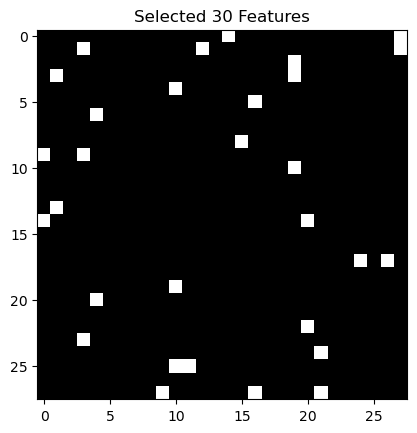

In [14]:
import numpy as np

data = prepare_mnist_data()

# randomly choose 30 features
np.random.seed(0)
selected_features = np.random.choice(data['trainX'].shape[1], 30, replace=False)
data['trainX'] = data['trainX'][:, selected_features]
data['testX'] = data['testX'][:, selected_features]
visualize_features(selected_features)

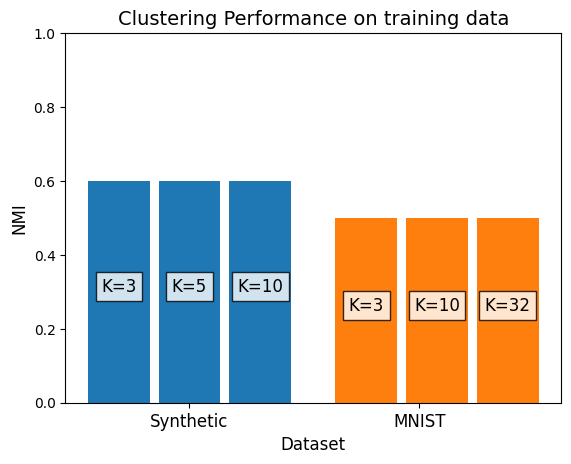

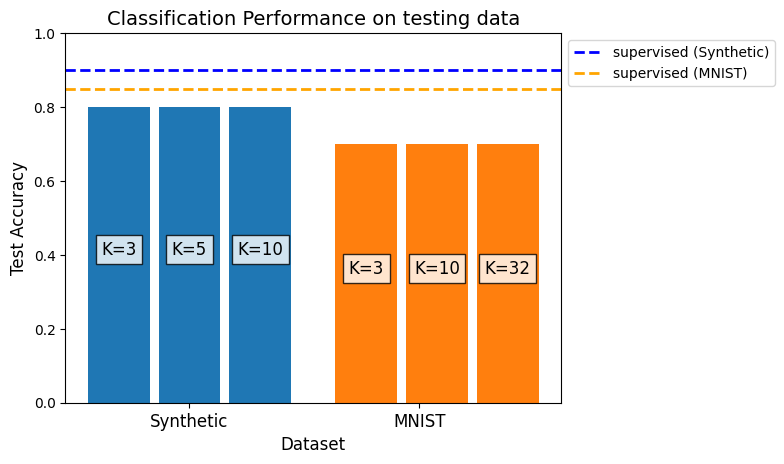

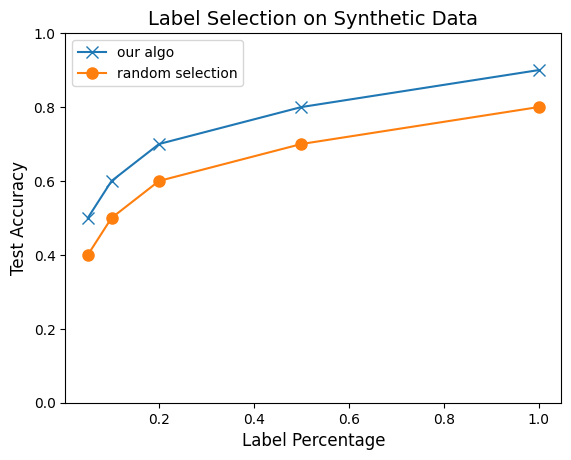

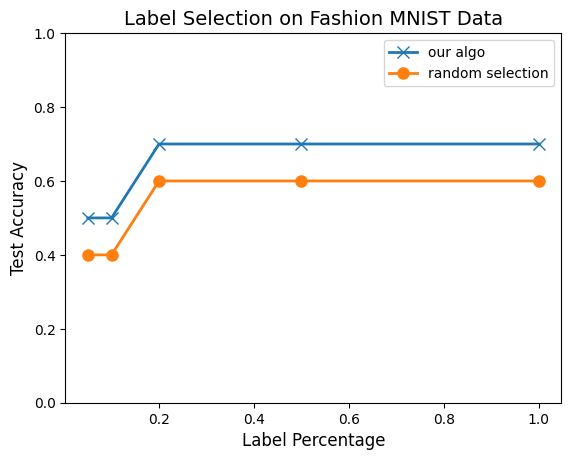

In [6]:
## TODO: Implement your solution and store the results in the following dictionaries
## Please note that the below values are given as an example to show the format, 
## you need to replace them with your values :)


# Task 1
result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}


# Task 2
result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[0.6,0.6,0.6], 'classification_accuracy':[0.8,0.8,0.8]},
            'mnist':{'K':[3, 10, 32], 'clustering_nmi':[0.5,0.5,0.5], 'classification_accuracy':[0.7,0.7,0.7]}}

# Task 3
# only include the plots for the option of task 3 you chosen in the report                    
result3_1 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.6,0.7,0.8,0.9], 'test_accuracy(random)':[0.4,0.5,0.6,0.7,0.8]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'test_accuracy(random)':[0.4,0.4,0.6,0.6,0.6]}}

result3_2 = {'feature_number':[5, 20, 80, 320, 784], 'classifier_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'classifier_accuracy(random)':[0.4,0.4,0.6,0.6,0.6], 
                                                'clustering_accuracy(our algo)':[0.35,0.35,0.45,0.55,0.6], 'clustering_accuracy(random)':[0.3,0.3,0.4,0.5,0.6], 
                                                'nmi(our algo)':[0.35,0.4,0.45,0.5,0.5], 'nmi(random)':[0.3,0.35,0.4,0.5,0.5]}


plot_result(result1 = result1, result2 = result2, result3_1 = result3_1)

# Alternatively
# plot_result(result1 = result1, result2 = result2, result3_2 = result3_2)

In [3]:
a = np.array([1,4,3,5,7])

In [4]:
a.argmax(axis=0)

np.int64(4)

In [13]:
a.argsort()[::-1][0:3]

array([4, 3, 1])